<a href="https://colab.research.google.com/github/willystw/fastai-learning/blob/shelter-animal/shelter-animal/Shelter_Animal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook waterfallcharts treeinterpreter dtreeviz
!pip install --upgrade --force-reinstall --no-deps kaggle
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 4.0 MB/s 
     |████████████████████████████████| 61 kB 579 kB/s 
     |████████████████████████████████| 1.2 MB 34.0 MB/s 
     |████████████████████████████████| 46 kB 4.4 MB/s 
     |████████████████████████████████| 186 kB 53.0 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 51 kB 323 kB/s 
     |████████████████████████████████| 58 kB 2.6 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=127afab3c3960f7b3c7ff61e8760a27a4d734d5f09a7ac3dd57bd866ffb5a3b5
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
Mounted at /content/gdrive


In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import zipfile, gzip

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [310]:
!rm -r ~/shelter-animal-outcomes
!mkdir ~/shelter-animal-outcomes
    
api.competition_download_cli('shelter-animal-outcomes', path='shelter-animal-outcomes')

with zipfile.ZipFile('shelter-animal-outcomes/shelter-animal-outcomes.zip','r') as zip_ref:
    zip_ref.extractall('data')

with gzip.open('data/sample_submission.csv.gz') as f:
    sample_submission = pd.read_csv(f)

with gzip.open('data/test.csv.gz') as f:
    test = pd.read_csv(f)

with gzip.open('data/train.csv.gz') as f:
    train = pd.read_csv(f, low_memory=False)


shelter-animal-outcomes.zip: Skipping, found more recently modified local copy (use --force to force download)


In [311]:
sample_submission.head()

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,1,0,0,0,0
1,2,1,0,0,0,0
2,3,1,0,0,0,0
3,4,1,0,0,0,0
4,5,1,0,0,0,0


In [312]:
test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


In [313]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,...,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,...,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,...,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,...,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,...,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,...,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [314]:
train['OutcomeType'].unique()

array(['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died'], dtype=object)

In [315]:
dep_var = 'OutcomeType'

In [316]:
cont, cat = cont_cat_split(train, 1 , dep_var)

In [317]:
procs = [Categorify, FillMissing]

In [318]:
train_tabular = TabularPandas(train, procs, cat, cont, y_names=dep_var, splits=RandomSplitter(valid_pct=0.2)(range_of(train)))

In [320]:
outcomes = ['Adoption','Died','Euthanasia', 'Return_to_owner','Transfer']

In [321]:
xs,y = train_tabular.train.xs, train_tabular.train.y

valid_x,valid_y = train_tabular.valid.xs, train_tabular.valid.y

In [322]:
len(train_tabular.train), len(train_tabular.valid)

(21384, 5345)

## Get important columns using Random Forest

In [323]:
def rf(xs, y, n_estimators=25, max_samples=10_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [324]:
m = rf(xs, y)

In [325]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [326]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [328]:
xs_drop = xs.drop(['OutcomeSubtype', 'DateTime'], axis=1)
valid_x_drop = valid_x.drop(['OutcomeSubtype','DateTime'], axis=1)

In [329]:
m = rf(xs_drop, y)

In [330]:
fi = rf_feat_importance(m, xs_drop)

In [331]:
m_rmse(m, xs_drop, y), m_rmse(m, valid_x_drop, valid_y)

(1.242638, 1.458582)

In [332]:
r_mse(m.oob_prediction_, y)

1.447983

In [333]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

7

In [334]:
xs_imp = xs_drop[to_keep]
valid_x_imp = valid_x_drop[to_keep]

In [335]:
m = rf(xs_imp, y)

In [336]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

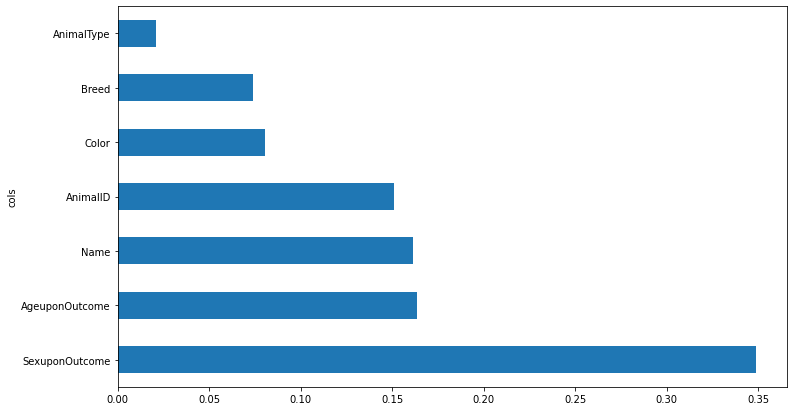

In [337]:
plot_fi(rf_feat_importance(m, xs_imp));

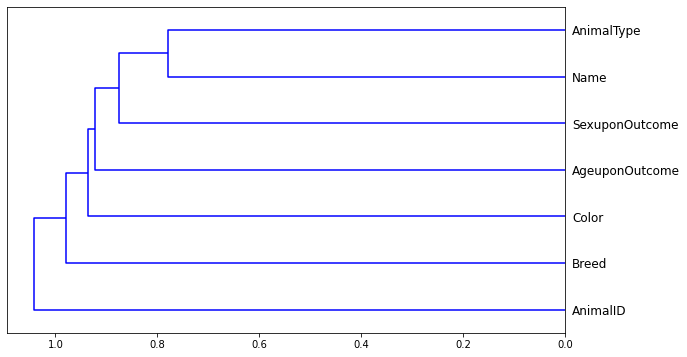

In [338]:
cluster_columns(xs_imp)

In [339]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=5000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [341]:
to_drop = []

In [342]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_x_final = valid_x_imp.drop(to_drop, axis=1)

In [343]:
df_dom = pd.concat([xs_final, valid_x_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_x_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
3,AnimalID,0.302065
1,Name,0.206530
4,Color,0.156347
5,Breed,0.138056
2,AgeuponOutcome,0.127679
0,SexuponOutcome,0.054949


In [344]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_x_final, valid_y))

for c in ('AnimalID','Name'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_x_final.drop(c,axis=1), valid_y))

orig 1.453772
AnimalID 1.462483
Name 1.450212


In [345]:
time_vars = ['AnimalID','Name']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_x_time = valid_x_final.drop(time_vars, axis=1)

In [346]:
m = rf(xs_final_time, y)
m_rmse(m, valid_x_time, valid_y)

1.463191

In [347]:
cont, cat

([],
 ['AnimalID',
  'Name',
  'DateTime',
  'OutcomeSubtype',
  'AnimalType',
  'SexuponOutcome',
  'AgeuponOutcome',
  'Breed',
  'Color'])

## Neural Network

In [348]:
with gzip.open('data/train.csv.gz') as f:
    train_nn = pd.read_csv(f, low_memory=False)


train_nn = add_datepart(train_nn, 'DateTime')

In [349]:
train_nn_final = train_nn[list(xs_final_time.columns) + [dep_var]]

In [350]:
cont_nn,cat_nn = cont_cat_split(train_nn_final, max_card=2000, dep_var=dep_var)

In [351]:
cont_nn, cat_nn

([], ['SexuponOutcome', 'AgeuponOutcome', 'Color', 'Breed', 'AnimalType'])

In [352]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(train_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=RandomSplitter(valid_pct=0.2)(range_of(train)), y_names=dep_var)

In [353]:
dls = to_nn.dataloaders(256)

In [354]:
dls.show_batch()

,SexuponOutcome,AgeuponOutcome,Color,Breed,AnimalType,OutcomeType
0,Neutered Male,7 years,White/Black,Lhasa Apso Mix,Dog,Transfer
1,Neutered Male,3 years,Black,Labrador Retriever Mix,Dog,Return_to_owner
2,Spayed Female,5 years,Brown Brindle,Pug Mix,Dog,Return_to_owner
3,Neutered Male,2 months,Orange Tabby,Domestic Medium Hair Mix,Cat,Adoption
4,Spayed Female,4 years,White,Angora Mix,Cat,Return_to_owner
5,Neutered Male,4 months,Brown Tabby,Domestic Medium Hair Mix,Cat,Adoption
6,Intact Male,2 years,Chocolate,Labrador Retriever,Dog,Transfer
7,Neutered Male,7 years,Brown/White,Chihuahua Shorthair Mix,Dog,Adoption
8,Neutered Male,2 years,Brown,Cairn Terrier Mix,Dog,Transfer
9,Intact Male,3 weeks,Brown Tabby/White,Domestic Shorthair Mix,Cat,Transfer


In [355]:
learn = tabular_learner(dls, layers=[500,250], loss_func= CrossEntropyLossFlat())

SuggestedLRs(valley=0.0004786300996784121)

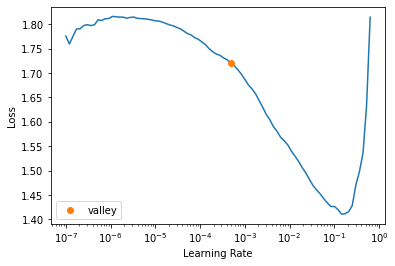

In [356]:
learn.lr_find()

In [357]:
learn.fit_one_cycle(2, 3e-2, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.994009,0.924340,00:01
1,0.877431,0.900081,00:01


SuggestedLRs(valley=5.754399353463668e-06)

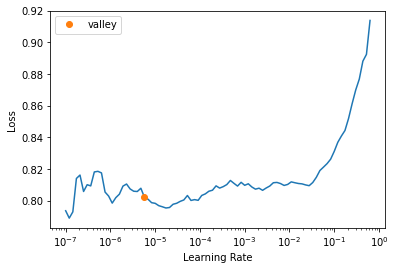

In [358]:
learn.lr_find()

In [359]:
learn.fit_one_cycle(4, 1e-5, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.813692,0.898392,00:01
1,0.813499,0.898239,00:01
2,0.808362,0.896984,00:01
3,0.813747,0.898480,00:01


In [369]:
learn.show_results()

,SexuponOutcome,AgeuponOutcome,Color,Breed,AnimalType,OutcomeType,OutcomeType_pred
0,3,37,87,641,1,0,0
1,1,22,105,641,1,4,4
2,2,21,105,641,1,4,4
3,3,25,325,1067,2,3,0
4,2,30,105,641,1,4,4
5,3,20,69,641,1,0,0
6,4,22,319,697,2,3,0
7,3,20,64,641,1,0,0
8,1,26,39,641,1,4,4


In [360]:
test_dl = learn.dls.test_dl(test)
predictions = learn.get_preds(dl=test_dl)

In [361]:
test_dl.show_batch()

,SexuponOutcome,AgeuponOutcome,Color,Breed,AnimalType
0,Intact Female,10 months,Red/White,Labrador Retriever Mix,Dog
1,Spayed Female,2 years,Black/Tan,German Shepherd/Siberian Husky,Dog
2,Neutered Male,1 year,Brown Tabby,Domestic Shorthair Mix,Cat
3,Intact Male,4 months,Tricolor,Collie Smooth Mix,Dog
4,Neutered Male,2 years,White,Miniature Poodle Mix,Dog
5,Neutered Male,3 years,Brown/White,Beagle Mix,Dog
6,Neutered Male,13 years,Brown Tabby/White,Domestic Medium Hair Mix,Cat
7,Spayed Female,6 months,Brown Tabby,Domestic Shorthair Mix,Cat
8,Spayed Female,3 months,Black/Cream,Cairn Terrier,Dog
9,Spayed Female,1 year,Brown/White,Pit Bull Mix,Dog


In [362]:
outcomes

['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']

In [363]:
x_df = pd.DataFrame(predictions[0])
x_df

,0,1,2,3,4
0,0.054832,0.007723,0.061115,0.200121,0.676209
1,0.860106,0.000903,0.001405,0.108109,0.029478
2,0.417169,0.003259,0.019317,0.121048,0.439207
3,0.151222,0.009524,0.048854,0.085078,0.705323
4,0.531108,0.001169,0.011453,0.321766,0.134503
...,...,...,...,...,...
11451,0.902577,0.001043,0.001055,0.005216,0.090109
11452,0.003507,0.010140,0.035353,0.006255,0.944745
11453,0.010146,0.008954,0.067026,0.024161,0.889713
11454,0.355090,0.002383,0.054917,0.445058,0.142551


In [364]:
x_df.rename(columns = dict(enumerate(outcomes)), inplace = True)

In [365]:
x_df.to_csv('result.csv')